In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd

In [2]:
tr = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [3]:
data = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=tr)

val_data = torch.utils.data.Subset(data, range(12000))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

train_data = torch.utils.data.Subset(data, range(12000, 60000))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

test_data = datasets.MNIST('./MNIST_data', download=True, train=False, transform=tr)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=True, num_workers=1)

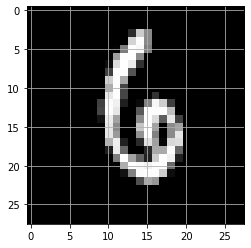

In [4]:
plt.imshow(train_data[2][0].reshape(28, 28), cmap='gray');

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 5, 3, padding=1),
                                    nn.BatchNorm2d(5),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        self.layer2 = nn.Sequential(nn.Conv2d(5, 5, 3, padding=1),
                                    nn.BatchNorm2d(5),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        self.layer3 = nn.Sequential(nn.Linear(245, 32),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.Linear(32, 10))

    def forward(self, X):
        X = self.layer1(X)
        X = self.layer2(X)
        X = X.reshape(X.size(0), -1)
        X = self.layer3(X)
        X = self.layer4(X)
        return X

    def evaluate(self, X):
        if len(X.size()) == 3:
            X.unsqueeze(0)
        Y = self.forward(X)
        return torch.argmax(Y, dim=1)

In [6]:
def is_overfitting(net, past_val_acc):
    val_x, val_y = [(x, y) for x, y in val_loader][0]
    predicted_class = net.evaluate(val_x)
    past_val_acc.append((predicted_class == val_y).float().mean().item())
    
    if len(past_val_acc) > 4 and sum(past_val_acc[-4:-2]) > sum(past_val_acc[-2:]):
        return True

    return False

In [7]:
net = Net()
params = list(net.parameters())
opt = optim.Adam(params)
criterion = nn.CrossEntropyLoss()

In [8]:
epochs = 10
past_val_acc = []
past_models = []

In [9]:
for i in range(epochs):
    for j, (inputs, labels) in enumerate(train_loader):
        opt.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()

        if (j + 1) % 100 == 0:
            print("Epoche:", i + 1, "Batch:", j + 1, "Loss:", loss.item())
            
    past_models.append(deepcopy(net))
    if is_overfitting(net, past_val_acc):
         break

Epoche: 1 Batch: 100 Loss: 0.5936825275421143
Epoche: 1 Batch: 200 Loss: 0.3167075514793396
Epoche: 1 Batch: 300 Loss: 0.272394061088562
Epoche: 1 Batch: 400 Loss: 0.3714227080345154
Epoche: 1 Batch: 500 Loss: 0.20686568319797516
Epoche: 1 Batch: 600 Loss: 0.25579261779785156
Epoche: 1 Batch: 700 Loss: 0.12753330171108246
Epoche: 2 Batch: 100 Loss: 0.09052973240613937
Epoche: 2 Batch: 200 Loss: 0.09029269218444824
Epoche: 2 Batch: 300 Loss: 0.046541277319192886
Epoche: 2 Batch: 400 Loss: 0.04127237945795059
Epoche: 2 Batch: 500 Loss: 0.2555873394012451
Epoche: 2 Batch: 600 Loss: 0.1328536570072174
Epoche: 2 Batch: 700 Loss: 0.11641748994588852
Epoche: 3 Batch: 100 Loss: 0.12668336927890778
Epoche: 3 Batch: 200 Loss: 0.1037973165512085
Epoche: 3 Batch: 300 Loss: 0.049126122146844864
Epoche: 3 Batch: 400 Loss: 0.04098806902766228
Epoche: 3 Batch: 500 Loss: 0.11066616326570511
Epoche: 3 Batch: 600 Loss: 0.03503258898854256
Epoche: 3 Batch: 700 Loss: 0.006119975354522467
Epoche: 4 Batch: 1

In [10]:
past_val_acc

[0.9375, 0.953125, 1.0, 0.953125, 0.953125]

In [15]:
#net = past_models[-2] #optional if other net performed better
net.train(False);

In [16]:
test_x, test_labels = [(data, target) for data, target in test_loader][0]
predicted_class = net.evaluate(test_x)

(predicted_class == test_labels).float().mean().item()

0.9811999797821045